### Bank customer's transactions prediction

#### Advanced classification algorithm with sickit-learn

A national bank makes a point of looking for ways to help its customers understand their financial health and identify products and services that could help them achieve their goals.

The purpose of this assessment is to help identify which of the bank's customers will make a specific transaction in the future, regardless of the amount of the transaction.

We have an anonymized dataset containing numeric variables as well as the binary target variable. This dataset is separated into a training set (train.csv) and a test set (test.csv).

An additional dataset (unlabeled.csv) contains additional but unlabeled data.

    The task is to build a model that can best predict the value of the target column on the test set.

A first Random Forest model has been trained on the training set, available in the file 'model.joblib'.

Load the training and test data sets. Load the pre-trained model, and evaluate the rate of good predictions on the test set


In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from joblib import dump, load
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.metrics import roc_auc_score,confusion_matrix,make_scorer,classification_report,roc_curve,auc
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from xgboost import XGBClassifier

Shape of X_train : (93000, 200)
Shape of X_test : (31000, 200)
Shape of y_train : (93000,)
Shape of y_test : (31000,)


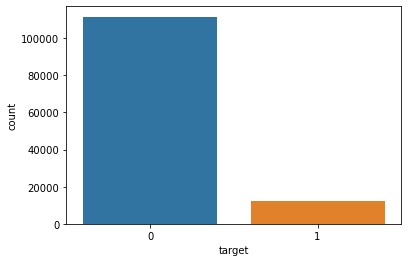

In [3]:
train_df = pd.read_csv("/Users/shahul/Desktop/santander-customer-transaction-prediction/train.csv")
test_df = pd.read_csv("/Users/shahul/Desktop/santander-customer-transaction-prediction/test.csv")

train_df.drop(train_df.index[124000:200000],0,inplace=True)
test_df.drop(test_df.index[31000:200000],0,inplace=True)


#preparing the data
X=train_df.drop(columns=['ID_code','target'],axis=1)
y=train_df['target']

#test_target=test_df['target']    # pour verifier plus tard avec le target de test

#analysing target values
sns.countplot(train_df.target)

#Split the training data
X_train,X_test,y_train,y_test=train_test_split(X,y)

print('Shape of X_train :',X_train.shape)
print('Shape of X_test :',X_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_test :',y_test.shape)




In [14]:
#import of pre-trained model 

#modelRF = load('model.joblib')
rf_model=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=42,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 



In [32]:
#Train the model using the training sets
rf_model.fit(X_train,y_train)  #modelRF.fit(X_train,y_train)

y_predRF = rf_model.predict(X_test) #y_predRF = modelRF.predict(X_test)



What is the score of the model? Is this metric relevant to our classification problem?

In [42]:

# let's evaluate the score of the obtained model and with test_target
y_predRF = rf_model.predict(X_test)
print("Accuracy score:",metrics.accuracy_score(y_test,y_predRF))

''' We can see on the graph above that about 90% of our data has 0 (the customer did not perform the transaction) and about 10% of the data has 
transaction). This shows that the problem to be solved is a binary classification problem and that this makes the data 
very unbalanced.
Choosing Accuracy for this model is not the best metric to use when evaluating unbalanced datasets, as it can be
misleading. So we will test other performance metrics.'''

#classification report
print(classification_report_imbalanced(y_test,y_predRF))

#roc_auc_score
AUC = roc_auc_score(y_test,y_predRF)
print("AUC score : ", AUC)

# Matrice de confusion
pd.crosstab(y_test,y_predRF, rownames = ["Classes réelles"], colnames = ["Classes prédites"])



Accuracy score: 0.900483870967742
                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      1.00      0.00      0.95      0.00      0.00     27918
          1       0.00      0.00      1.00      0.00      0.00      0.00      3082

avg / total       0.81      0.90      0.10      0.85      0.00      0.00     31000

AUC score :  0.49994627122286694


Classes prédites,0,1
Classes réelles,,
0,27915,3
1,3082,0


Propose a better model to detect transactions, and evaluate it with a better metric.

In [12]:
#methode manuelle
#y1 = y.drop(y.index[31000:124000],0) 
#y_pred - y1
#errors = sum(y_pred != y1) 
#print("Nb erreurs:", errors)
#print( "Pourcentage de prédiction juste:", (31000-errors)*100/31000) 

from imblearn.ensemble import BalancedRandomForestClassifier

bclf = BalancedRandomForestClassifier()
bclf.fit(X_train, y_train) 
y_pred_bclf = bclf.predict(X_test)

#matric confusion
print(pd.crosstab(y_test, y_pred_bclf))

#auc score 
AUC = roc_auc_score(y_test, y_pred_bclf)
print("AUC score : ", AUC)

#classification report
print(classification_report_imbalanced(y_test,y_pred_bclf))

col_0       0     1
target             
0       20768  7150
1         768  2314
AUC score :  0.7473519952912996
                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      0.74      0.75      0.84      0.75      0.56     27918
          1       0.24      0.75      0.74      0.37      0.75      0.56      3082

avg / total       0.89      0.74      0.75      0.79      0.75      0.56     31000



In [9]:
# Fitting XGBoost to the Training set
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 42, n_jobs = -1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [11]:
#matrix confusion 
print(pd.crosstab(y_test, y_pred))

#auc score 
AUC = roc_auc_score(y_test, y_pred)
print("AUC score : ", AUC)

#classification report
print(classification_report_imbalanced(y_test,y_pred))

col_0       0    1
target            
0       27610  308
1        2398  684
AUC score :  0.6054507501550731
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.99      0.22      0.95      0.47      0.24     27918
          1       0.69      0.22      0.99      0.34      0.47      0.20      3082

avg / total       0.90      0.91      0.30      0.89      0.47      0.23     31000



In [ ]:
'''
 as we have imbalanced data here we can try Oversampling minority class wich is good when less data but drawback is
 that we are adding information.This may leads to overfitting and poor performance on test data.
 On opossite undersampling majority class could be a good choice when big data but drawback is that we are removing
 information that may be valuable.This may leads to underfitting and poor performance on test data.

 So Both Oversampling and undersampling techniques have some drawbacks. So, we are not going to use this models
 for this problem and also we will use other best algorithms'''

'''Synthetic Minority Oversampling Technique(SMOTE) could be a good one lets try it'''

In [28]:
y_test_train = train_df.drop(train_df.index[31000:124000])
w1 = y_test_train.target

In [30]:
y_test_train.shape
w1.shape
print(pd.crosstab(y_test, w1))




target     0    1
target           
0       6967    0
1          0  759


In [ ]:
''' judging by the resul smote is the most compatible for this kind of datasets'''